Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer
# from keras.callbacks import EarlyStopping #, ReduceLROnPlateau

In [ ]:
def plot_metrics(history, epochs=20):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

#To Remove Augemented Images from Dataset, we will create following method/function

import shutil

def remove_output_files():
  class_names = ['pigmented benign keratosis', 
                'melanoma', 
                'basal cell carcinoma', 
                'nevus', 
                'squamous cell carcinoma', 
                'vascular lesion', 
                'actinic keratosis', 
                'dermatofibroma', 
                'seborrheic keratosis']
  data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
  for i in class_names:
    dir_path = str(data_dir_train) + '/' + str(i)+'/output'
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt

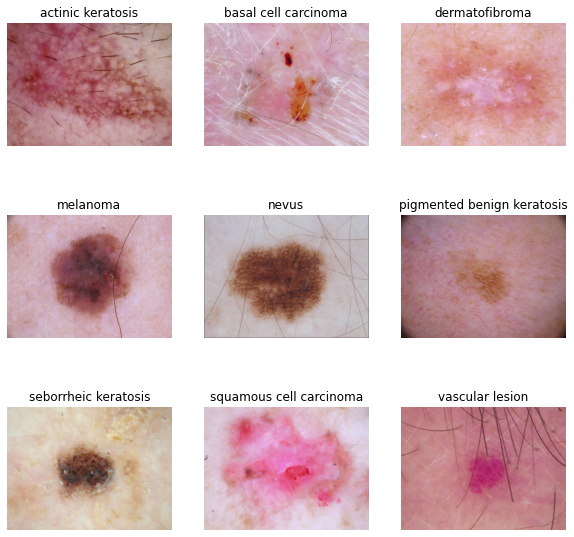

In [ ]:
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)
  
  

In [ ]:
images, labels= next(iter(train_ds))
print(images.shape)
print(labels.shape)

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Creating and testing how Keras Rescaling layer works

normalization_layer = tf.keras.layers.Rescaling(1./255)


normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027287697 0.9785949


## Model 1 - Vanilla Model

In [ ]:
model=Sequential()
model.add(InputLayer((180,180,3)))
model.add(Rescaling(1./255))

model.add(Conv2D(32, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(9, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### As Adam is the most popular Optmizers and works well on most of the NN Problems. 
### Also, We are having Muti-class classification problem we will choose Loss as SparseCategoricalCrossentropy.
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 57s 846ms/step - loss: 3.5106 - accuracy: 0.2561 - val_loss: 1.6712 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6413 - accuracy: 0.4085 - val_loss: 1.4779 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4488 - accuracy: 0.4855 - val_loss: 1.7792 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4177 - accuracy: 0.5100 - val_loss: 1.5265 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.2486 - accuracy: 0.5586 - val_loss: 1.4907 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 5s 88ms/step - loss: 1.1431 - accuracy: 0.5898 - val_loss: 1.4374 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.0596 - accuracy: 0.6289 - val_loss: 1.6280 - val_accuracy: 0.5078
Epoch 8/20


### Visualizing training results

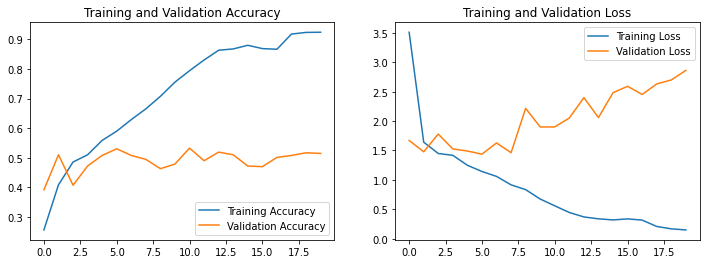

In [ ]:
plot_metrics(history)

#### We observe that Model 1 overfits the data exteremly. We need to resolve the issue  of overfitting with several techniques. I.e Dropout, Data Augmentation, and Batch Normalization,

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# We will use ImageDataGenerator to try for Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_aug=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)

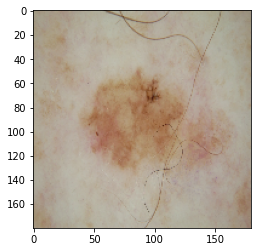

In [ ]:
image_batch,label_batch=next(iter(train_ds))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

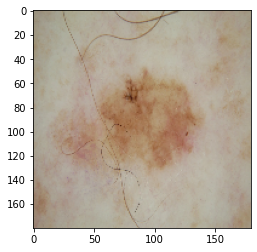

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.imshow(image_aug.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Model 2 with Dropout layers
### Create the model, compile and train the model 


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_dp=Sequential()

model_dp.add(InputLayer((180,180,3)))
model_dp.add(Rescaling(1./255))

model_dp.add(Conv2D(32, 3, activation='relu',padding='same'))
model_dp.add(MaxPooling2D())

model_dp.add(Conv2D(64, 3, activation='relu',padding='same'))
model_dp.add(MaxPooling2D())
model_dp.add(Dropout(0.20))

model_dp.add(Flatten())
model_dp.add(Dense(256, activation='relu'))
model_dp.add(Dropout(0.20))

model_dp.add(Dense(9, activation='softmax'))


# View the summary of all layers
model_dp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)       

### Compiling the model

In [ ]:
#choose an appropirate optimiser and loss function
model_dp.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [ ]:
epochs = 20
history_dp = model_dp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 77ms/step - loss: 3.0796 - accuracy: 0.2506 - val_loss: 1.8934 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.7874 - accuracy: 0.3571 - val_loss: 1.9051 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6371 - accuracy: 0.4286 - val_loss: 1.6197 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 4s 75ms/step - loss: 1.5183 - accuracy: 0.4782 - val_loss: 1.4212 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 1.3314 - accuracy: 0.5357 - val_loss: 1.4459 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.2128 - accuracy: 0.5670 - val_loss: 1.4745 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.1646 - accuracy: 0.5926 - val_loss: 1.4169 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing the results

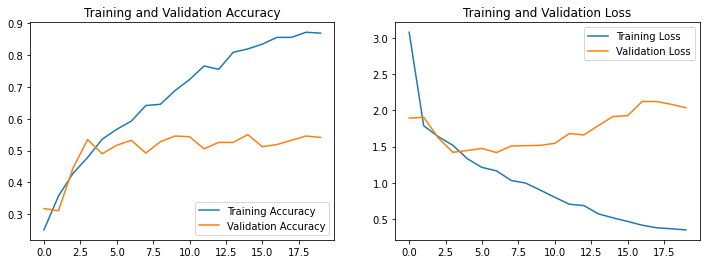

In [ ]:
plot_metrics(history_dp)

#### Obervation: We have reduced the overfitting problem slighlty. However, There is no significant improvement with Model 2 in comparison to Model 1. We assume the issue to be Lower Amount of Data and Class Imbalance.

#### Let's start Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


#### Observations: 
#### - *'seborrheic keratosis'* class has the least number of samples.
#### - 'pigmented benign keratosis' classes dominate the data in terms proportionate number of samples


In [ ]:
import os
import glob
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list)

lesion_list = list()

#for [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
for i in glob(os.path.join(data_dir_train, '*', '*.jpg')):
  base_dir_name = os.path.dirname(i)
  #print(base_dir_name)
  lesion_list.append(os.path.basename(base_dir_name))

print(lesion_list)

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_00260

In [ ]:
import pandas as pd

dataframe_dict = dict(zip(path_list, lesion_list))

original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

Path              Label
0     /content/drive/MyDrive/CNN_assignment/Skin can...  actinic keratosis
1     /content/drive/MyDrive/CNN_assignment/Skin can...  actinic keratosis
2     /content/drive/MyDrive/CNN_assignment/Skin can...  actinic keratosis
3     /content/drive/MyDrive/CNN_assignment/Skin can...  actinic keratosis
4     /content/drive/MyDrive/CNN_assignment/Skin can...  actinic keratosis
...                                                 ...                ...
2234  /content/drive/MyDrive/CNN_assignment/Skin can...    vascular lesion
2235  /content/drive/MyDrive/CNN_assignment/Skin can...    vascular lesion
2236  /content/drive/MyDrive/CNN_assignment/Skin can...    vascular lesion
2237  /content/drive/MyDrive/CNN_assignment/Skin can...    vascular lesion
2238  /content/drive/MyDrive/CNN_assignment/Skin can...    vascular lesion

[2239 rows x 2 columns]

In [ ]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### Rectify the class imbalance
#### We'll use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
balance_file_count = 1000
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  current_count = len(list(data_dir_train.glob('{}/*.jpg'.format(i))))
  augmnt_pipeline.sample(balance_file_count - current_count)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3A9B4FB90>: 100%|██████████| 886/886 [00:43<00:00, 20.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3A9B45950>: 100%|██████████| 624/624 [00:30<00:00, 20.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4C02976D0>: 100%|██████████| 905/905 [00:44<00:00, 20.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF3A988DF10>: 100%|██████████| 562/562 [01:52<00:00,  5.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FF3A978B890>: 100%|██████████| 643/643 [02:12<00:00,  4.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF3A98BECD0>: 100%|██████████| 538/538 [00:27<00:00, 19.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF3A9BBAFD0>: 100%|██████████| 923/923 [01:40<00:00,  9.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF4237765D0>: 100%|██████████| 819/819 [00:40<00:00, 20.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF420045E90>: 100%|██████████| 861/861 [00:43<00:00, 19.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6761


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1000
squamous cell carcinoma       1000
seborrheic keratosis          1000
melanoma                      1000
actinic keratosis             1000
nevus                         1000
basal cell carcinoma          1000
dermatofibroma                1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
augmented_data_dir = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
model_norm=Sequential()

model_norm.add(InputLayer((180,180,3)))
model_norm.add(Rescaling(1./255))

model_norm.add(Conv2D(32, (3, 3), padding='same'))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))

model_norm.add(MaxPooling2D(pool_size=(2, 2)))

model_norm.add(Conv2D(64, (3, 3)))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))


model_norm.add(MaxPooling2D(pool_size=(2, 2)))
model_norm.add(Dropout(0.25))

model_norm.add(Flatten())
model_norm.add(Dense(512, activation='relu',kernel_regularizer=l2(0.01)))
model_norm.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model_norm.add(Dropout(0.25))

model_norm.add(Dense(9, activation='softmax'))


# View the summary of all layers
model_norm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_15 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 88, 88, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
#choose an appropirate optimiser and loss function
model_norm.compile(optimizer='SGD',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history_norm = model_norm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
225/225 [==============================] - 64s 274ms/step - loss: 14.9797 - accuracy: 0.3668 - val_loss: 14.9220 - val_accuracy: 0.1372
Epoch 2/50
225/225 [==============================] - 64s 281ms/step - loss: 13.1508 - accuracy: 0.5415 - val_loss: 12.9677 - val_accuracy: 0.4189
Epoch 3/50
225/225 [==============================] - 65s 283ms/step - loss: 11.9211 - accuracy: 0.6361 - val_loss: 11.5417 - val_accuracy: 0.5883
Epoch 4/50
225/225 [==============================] - 62s 271ms/step - loss: 10.8278 - accuracy: 0.7129 - val_loss: 10.5196 - val_accuracy: 0.6594
Epoch 5/50
225/225 [==============================] - 68s 299ms/step - loss: 9.8749 - accuracy: 0.7492 - val_loss: 10.1151 - val_accuracy: 0.5372
Epoch 6/50
225/225 [==============================] - 68s 299ms/step - loss: 8.9769 - accuracy: 0.8028 - val_loss: 9.3781 - val_accuracy: 0.5522
Epoch 7/50
225/225 [==============================] - 66s 287ms/step - loss: 8.1986 - accuracy: 0.8301 - val_loss: 7.9985

#### **Todo:**  Visualize the model results

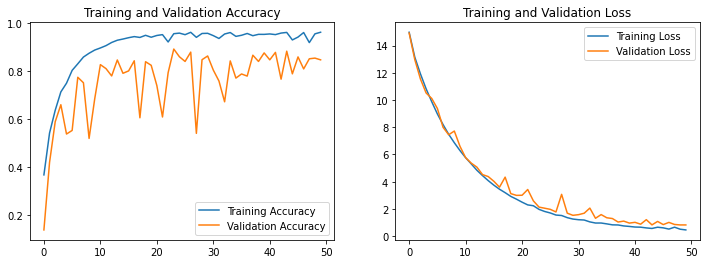

In [ ]:
plot_metrics(history_norm,epochs=50)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Final Conclusion

## We observe successive improvement from Model 1 to Model 3:

# Model 1:
#### Simple CNN Model | Accuracy: 0.9241  | Validation accuracy : 0.5145

# Model 2:
#### CNN Model with Dropout | Accuracy: 0.8694  | Validation accuracy : 0.5414

# Model 3:
#### CNN Model with Augmented Data, Dropout and Batch Normalization | Accuracy: 0.9618  | Validation accuracy : 0.8467